In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from pprint import pprint as print
import statsmodels.api as sm
import numpy as np

In [81]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
risk_free = .06

In [32]:
assets = ['date','DSEX', 'UPGDCL', 'MONNOSTAF', 'DAFODILCOM', 'RECKITTBEN']

In [79]:
def YtoM(y):
    return (1 + y) **(1/12) - 1

In [80]:
print(YtoM(.12))

0.009488792934583046


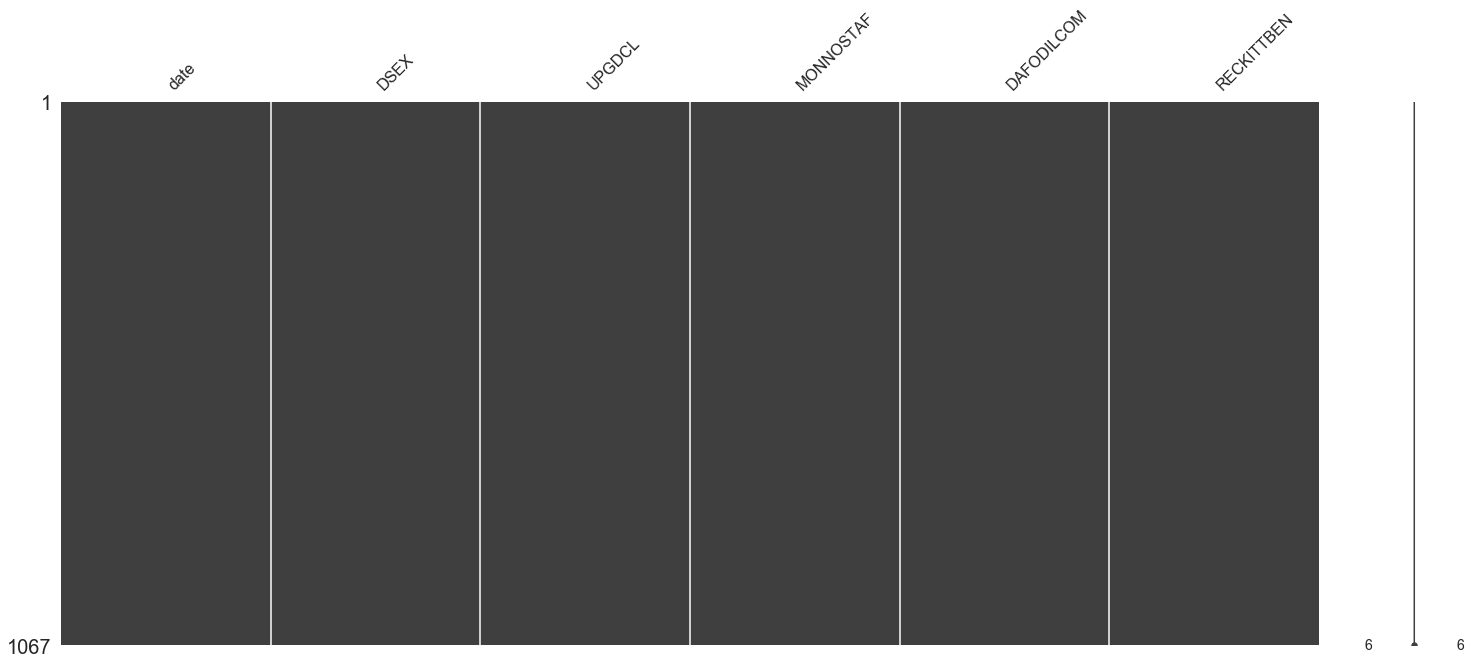

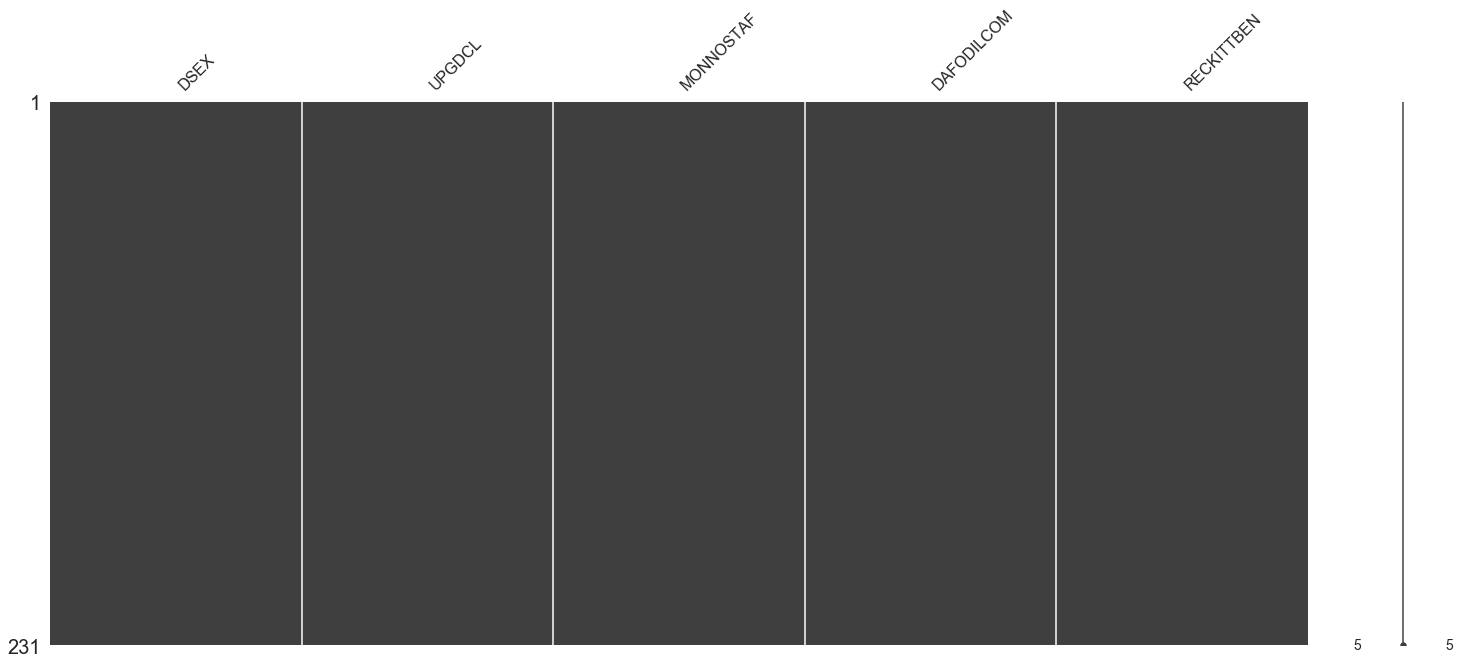

In [200]:
df = pd.read_csv('./stocks-pivoted-dataframe.csv').loc[:, assets].fillna(method='ffill').dropna()
df_daily = df.set_index(pd.to_datetime(df['date']))
df_weekly = df_daily.resample('W').mean()
msno.matrix(df_daily)
msno.matrix(df_weekly)

In [34]:
df.head()

,date,DSEX,UPGDCL,MONNOSTAF,DAFODILCOM,RECKITTBEN
4064,2015-04-05,4431.11,134.6,283.2,12.1,1621.3
4065,2015-04-06,4397.26,128.1,291.1,12.1,1606.1
4066,2015-04-07,4345.03,148.2,289.6,11.7,1544.8
4067,2015-04-08,4347.14,153.6,287.8,11.9,1581.4
4068,2015-04-09,4345.89,145.3,281.7,12.0,1560.7


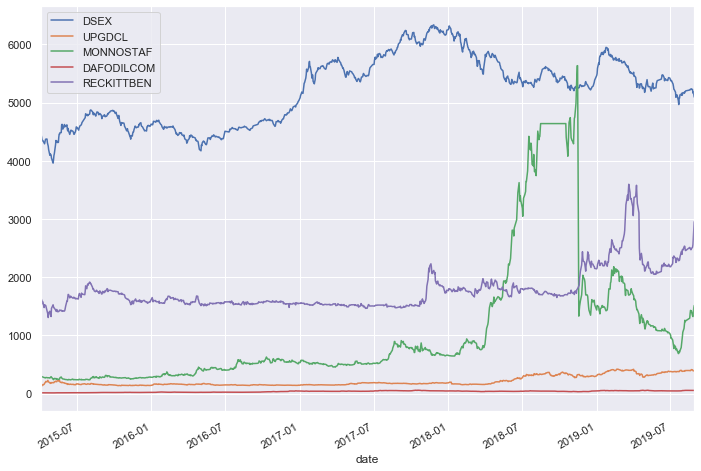

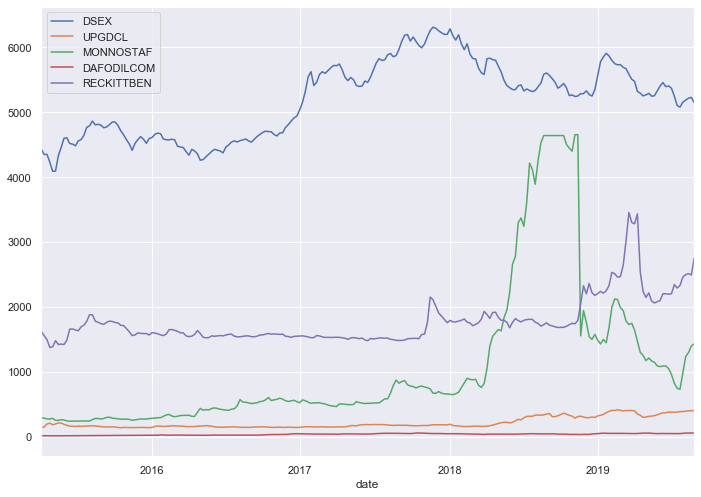

In [35]:
df_daily.plot()
df_weekly.plot()

In [98]:
ols_summary = summary_df.transpose()
ols_summary

,Variance,Annual Return
DSEX,0.001448,-0.024229
UPGDCL,0.013747,0.201783
MONNOSTAF,0.052001,0.360139
DAFODILCOM,0.017922,0.323334
RECKITTBEN,0.011824,0.063294


In [192]:
def Alpha_Beta(df_returns):
    symbols = df_returns.columns.values.tolist()
    #symbols.remove('DSEX')
    ols_summary = pd.DataFrame()
    for symbol in symbols:
        x = df_returns['DSEX']
        X = sm.add_constant(x)
        Y = df_returns[symbol]
        model = sm.OLS(Y,X).fit()
        ols_summary = ols_summary.append({
            'symbol': symbol,
            'alpha': model.params[0],
            'beta': model.params[1],
            'adj beta': model.params[1]*.667+.333,
            'regression variance': model.ess/len(Y) * 52,
            'residual variance': model.ssr/len(Y) * 52

        },
                                        ignore_index = True)
    return ols_summary.set_index('symbol')



In [193]:
risk_free = .06
risk_free_w = (1+risk_free)**(1/52) - 1
w_return = df_weekly.pct_change().dropna()
w_premium = w_return - risk_free_w
summary_df = pd.DataFrame([w_premium.var() * 52, w_premium.apply(lambda x: x +1).cumprod().iloc[-1]  ** (52/len(w_premium)) -1 ], index=['Variance', 'Annual Return'])
## using definition of alpha and beta
ols_summary = Alpha_Beta(w_premium)
risk_params_df = pd.concat([summary_df.transpose(), ols_summary, w_premium.corr().loc[:, 'DSEX'].rename('Correlation with Market')],axis=1)

/Users/xebra/Desktop/Projects/quantitative-finance/portfolio-analysis/sy-portfolio/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [194]:
si_securities = risk_params_df.drop(index='DSEX')

In [195]:
si_securities['initial position'] = si_securities['alpha']/si_securities['residual variance']

In [196]:
si_securities['percent position'] = si_securities['initial position'] / si_securities['initial position'].sum()
si_securities


,Variance,Annual Return,adj beta,alpha,beta,regression variance,residual variance,Correlation with Market,initial position,percent position
symbol,,,,,,,,,,
UPGDCL,0.099129,0.201783,0.788236,0.004713,0.682512,0.004843,0.093855,0.221523,0.050215,0.318006
MONNOSTAF,0.374985,0.360139,0.455876,0.010316,0.184221,0.000353,0.373001,0.030743,0.027657,0.175149
DAFODILCOM,0.129239,0.323334,0.830327,0.006861,0.745617,0.005780,0.122896,0.211948,0.055831,0.353573
RECKITTBEN,0.085261,0.063294,0.423996,0.002050,0.136425,0.000194,0.084697,0.047745,0.024202,0.153271


In [217]:
active_portfolio = pd.DataFrame().append({
    'port_alpha' : si_securities['alpha'].dot(si_securities['percent position']),
    'port_beta' : si_securities['adj beta'].dot(si_securities['percent position']),
    'port_residual' : si_securities['residual variance'].dot(si_securities['percent position']**2),
    'market_premium': .03,
    'market_variance': risk_params_df.loc['DSEX', 'Variance']}, ignore_index=True).transpose()[0]


In [226]:
ini_active_weight = (active_portfolio['port_alpha']/active_portfolio['port_residual'])/(active_portfolio['market_premium']/active_portfolio['market_variance'])
active_weight = ini_active_weight/(1 + (1- active_portfolio['port_beta'])*ini_active_weight)
passive_weight = 1 - active_weight
passive_weight

0.9459573091769313

In [188]:
(df_weekly['DSEX'].iloc[-1]/df_weekly['DSEX'].iloc[0] )**(1/3) - 1

0.05105644870755244

In [190]:
df_weekly.DSEX.pct_change().dropna().apply(lambda x: x+1).cumprod().iloc[-1]**(52/len(df_weekly.index)) - 1

0.03420015665058451

In [191]:
df_weekly

,DSEX,UPGDCL,MONNOSTAF,DAFODILCOM,RECKITTBEN
date,,,,,
2015-04-05,4431.1100,134.600,283.200,12.100000,1621.300
2015-04-12,4348.1180,147.000,284.860,11.900000,1554.100
2015-04-19,4349.7825,193.425,271.850,11.575000,1493.800
2015-04-26,4226.2680,206.380,269.820,11.460000,1372.400
2015-05-03,4088.3300,182.000,280.700,10.966667,1383.700
...,...,...,...,...,...
2019-08-04,5153.4320,384.120,982.960,49.640000,2458.500
2019-08-11,5184.0725,391.050,1231.400,53.900000,2495.475
2019-08-18,5216.5400,395.400,1294.700,54.400000,2510.500


In [198]:
w_premium.head()

,DSEX,UPGDCL,MONNOSTAF,DAFODILCOM,RECKITTBEN
date,,,,,
2015-04-12,-0.019851,0.091004,0.004740,-0.017650,-0.042569
2015-04-19,-0.000738,0.314695,-0.046793,-0.028432,-0.039922
2015-04-26,-0.029517,0.065856,-0.008589,-0.011056,-0.082390
2015-05-03,-0.033759,-0.119253,0.039202,-0.044169,0.007113
2015-05-10,-0.000059,0.065912,-0.108139,-0.029085,0.067275


In [199]:
risk_params_df.head()

,Variance,Annual Return,adj beta,alpha,beta,regression variance,residual variance,Correlation with Market
symbol,,,,,,,,
DSEX,0.010443,-0.024229,1.000000,5.014435e-19,1.000000,0.010397,1.132325e-35,1.000000
UPGDCL,0.099129,0.201783,0.788236,4.712937e-03,0.682512,0.004843,9.385509e-02,0.221523
MONNOSTAF,0.374985,0.360139,0.455876,1.031614e-02,0.184221,0.000353,3.730013e-01,0.030743
DAFODILCOM,0.129239,0.323334,0.830327,6.861476e-03,0.745617,0.005780,1.228964e-01,0.211948
RECKITTBEN,0.085261,0.063294,0.423996,2.049881e-03,0.136425,0.000194,8.469724e-02,0.047745


In [205]:
regression_df = pd.DataFrame()
for symbol in w_premium.columns.values:
    model = risk_params_df.loc[symbol, ['alpha', 'beta']]
    regression_df[symbol] = w_premium['DSEX']*model['beta'] + model['alpha']

In [209]:
residual_df = w_premium - regression_df

In [210]:
residual_df.corr()

,DSEX,UPGDCL,MONNOSTAF,DAFODILCOM,RECKITTBEN
DSEX,1.000000,-0.032643,0.070208,-0.020163,0.041100
UPGDCL,-0.032643,1.000000,0.016870,-0.137017,0.011908
MONNOSTAF,0.070208,0.016870,1.000000,0.124721,-0.046707
DAFODILCOM,-0.020163,-0.137017,0.124721,1.000000,-0.170952
RECKITTBEN,0.041100,0.011908,-0.046707,-0.170952,1.000000
